This notebook targets Databricks Community!  
  
Source dataset: Chicago data portal, food inspection data (engineered dataset Food_Inspections1.csv & Food_Inspections2.csv taken from Azure HDInsight)  
Upload it into Databricks dbfs://FileStore/tables/

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row
from pyspark.sql.functions import udf #UserDefinedFunction
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [3]:
%fs ls /FileStore/tables/

path,name,size
dbfs:/FileStore/tables/Food_Inspections1.csv,Food_Inspections1.csv,19085447
dbfs:/FileStore/tables/Food_Inspections2.csv,Food_Inspections2.csv,14330038


In [4]:
def readDataset(fp) :
  # Food_Inspections1.csv dataset file was uploaded to Databricks filestore
  df = spark.read.csv(fp, 
                           header=True, 
                           multiLine=True, 
                           ignoreLeadingWhiteSpace=True, 
                           ignoreTrailingWhiteSpace=True, 
                           encoding="UTF-8",
                           sep=',',
                           quote='"', 
                           escape='"',
                           maxColumns=17,
                           inferSchema=True)

  df = df.select(col("Inspection ID").alias("id"), col("DBA Name").alias("name"), col("Results").alias("results"), col("Violations").alias("violations"))
  df = df.na.fill({'violations': ''})
  return df

In [5]:
# Training dataset (with 'results' as label)
train_df = readDataset("/FileStore/tables/Food_Inspections1.csv")
train_df.show(5)

+------+--------------------+-------+--------------------+
 id| name|results| violations|
+------+--------------------+-------+--------------------+
413707| LUNA PARK INC| Fail|24. DISH WASHING ...|
391234| CAFE SELMARIE| Fail|2. FACILITIES TO ...|
413751| MANCHU WOK| Pass|33. FOOD AND NON-...|
413708|BENCHMARK HOSPITA...| Pass| |
413722| JJ BURGER| Pass| |
+------+--------------------+-------+--------------------+
only showing top 5 rows

In [6]:
# NOTE that 'results' has 5 types for the food inspection classification, but this problem domain is being filtered to obtain binary problme domain (refer to UDF below)
train_df.select('results').distinct().show()

+--------------------+
 results|
+--------------------+
 Fail|
Business Not Located|
 Pass w/ Conditions|
 Out of Business|
 Pass|
+--------------------+

In [7]:
# Retaining pass/fail and filtering out remaining inspections to focus on binary classification
def labelForResults(s):
    if s == 'Fail':
        return 0.0
    elif s == 'Pass w/ Conditions' or s == 'Pass':
        return 1.0
    else:
        return -1.0
udfLabelResult = udf(labelForResults, DoubleType())

labeledTrainingData = train_df.select(udfLabelResult(train_df.results).alias('label'), train_df.violations).where('label >= 0')
labeledTrainingData.show(5)

+-----+--------------------+
label| violations|
+-----+--------------------+
 0.0|24. DISH WASHING ...|
 0.0|2. FACILITIES TO ...|
 1.0|33. FOOD AND NON-...|
 1.0| |
 1.0| |
+-----+--------------------+
only showing top 5 rows

In [8]:
tokenizer = Tokenizer(inputCol="violations", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

model = pipeline.fit(labeledTrainingData)

In [9]:
# Model looks for just 'violations' column for predicting
# Note that same pipeline of Tokenizer & HashingTF is implicitly applied on the test data which is then used for prediction
test_df = readDataset("/FileStore/tables/Food_Inspections2.csv")

predictions_df = model.transform(test_df)
predictions_df = predictions_df.select(udfLabelResult(predictions_df.results).alias('label'), predictions_df.violations, predictions_df.prediction).where('label >= 0')
predictions_df.show(5)

+-----+--------------------+----------+
label| violations|prediction|
+-----+--------------------+----------+
 0.0|37. TOILET ROOM D...| 0.0|
 1.0| | 1.0|
 1.0|9. WATER SOURCE: ...| 1.0|
 1.0|29. PREVIOUS MINO...| 1.0|
 1.0|2. FACILITIES TO ...| 1.0|
+-----+--------------------+----------+
only showing top 5 rows

In [10]:
tp = predictions_df[(predictions_df.label == 1) & (predictions_df.prediction == 1)].count()
tn = predictions_df[(predictions_df.label == 0) & (predictions_df.prediction == 0)].count()
fp = predictions_df[(predictions_df.label == 0) & (predictions_df.prediction == 1)].count()
fn = predictions_df[(predictions_df.label == 1) & (predictions_df.prediction == 0)].count()
(tp, tn, fp, fn)

Out[ 68 ]: (6868, 1242, 976, 229)

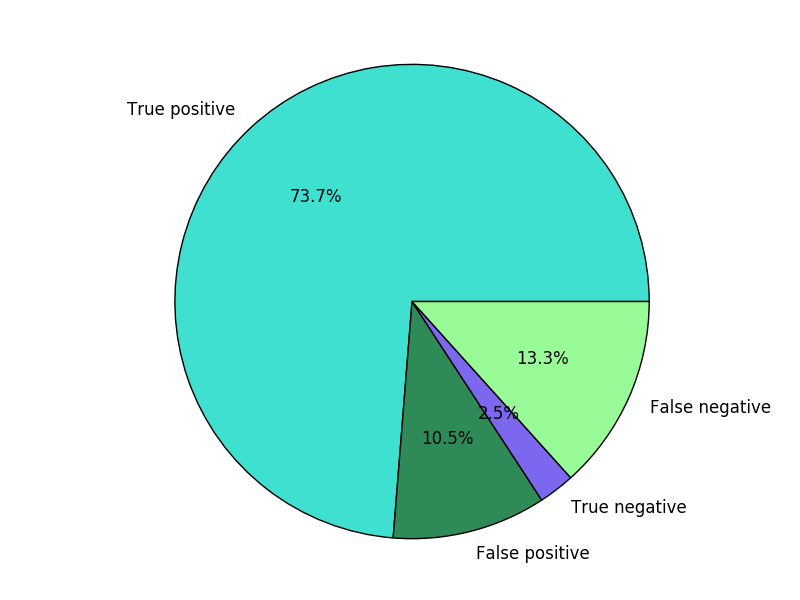

In [11]:
#%matplotlib inline
import matplotlib.pyplot as plt

labels = ['True positive', 'False positive', 'True negative', 'False negative']
sizes = [tp, fp, fn, tn]
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
ax.axis('equal')
display(fig)